# Project Breathless: Comprehensive Analysis of Air Pollution, Demographics, and Health Outcomes

## 1. Setup and Initialization

In [1]:
import os
import glob
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visual Polish
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
palette = sns.color_palette("viridis")

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_date, year, avg, lag, coalesce, when, regexp_replace, lower, trim
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Initialize Spark Session
spark = (SparkSession.builder
         .appName("Breathless_Analysis")
         .master("local[16]")
         .config("spark.driver.memory", "16g")
         .config("spark.sql.shuffle.partitions", "128")
         .getOrCreate())

print("Spark Session Created")

Spark Session Created


## 2. Data Ingestion and Cleaning

We will load and clean datasets from WHO, UN, and EPA sources.

In [2]:
# Helper function to load UN CSVs with specific structure (header on row 2)
def load_un_data(path, value_col_name, series_filter=None):
    if not os.path.exists(path):
        print(f"Warning: File not found: {path}")
        return None
    
    try:
        pdf = pd.read_csv(path, header=1)
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None
    
    pdf = pdf.drop(columns=["Footnotes", "Source"], errors='ignore')
    
    if 'Value' in pdf.columns:
        pdf['Value'] = pdf['Value'].astype(str)
    else:
        return None
    
    sdf = spark.createDataFrame(pdf)
    
    target_country_col = None
    if "Unnamed: 1" in sdf.columns:
        target_country_col = "Unnamed: 1"
    elif "Region/Country/Area" in sdf.columns:
        sample_val = str(pdf.iloc[0, 0]) if not pdf.empty else ""
        if sample_val.isdigit():
             if len(sdf.columns) > 1:
                 target_country_col = sdf.columns[1]
        else:
             target_country_col = "Region/Country/Area"
    else:
        target_country_col = sdf.columns[1] if len(sdf.columns) > 1 else sdf.columns[0]

    clean_sdf = sdf.select(
        trim(col(target_country_col)).alias("Country"),
        col("Year").cast("int"),
        col("Series"),
        regexp_replace(col("Value"), ",", "").cast("double").alias("Value")
    )
    
    if series_filter:
        clean_sdf = clean_sdf.filter(col("Series") == series_filter)
        clean_sdf = clean_sdf.withColumnRenamed("Value", value_col_name).drop("Series")
        
    return clean_sdf

# 2.1 Load WHO Mortality (Target Variable)
who_mortality_path = "who attribate deaths per 1000 standarised/data.csv"
who_df = spark.read.option("header", "true").option("inferSchema", "true").csv(who_mortality_path)
who_clean_df = who_df.select(
    trim(col("Location")).alias("Country"),
    col("Period").cast("int").alias("Year"),
    col("FactValueNumeric").alias("DeathRate")
).filter(col("Dim1") == "Both sexes")

# 2.2 Load WHO PM2.5 (Key Predictor)
who_pm25_path = "who pm2.5/dataall.csv"
who_pm25_df = spark.read.option("header", "true").option("inferSchema", "true").csv(who_pm25_path)
who_pm25_clean = who_pm25_df.select(
    trim(col("Location")).alias("Country"),
    col("Period").cast("int").alias("Year"),
    col("FactValueNumeric").alias("PM25")
).filter(col("Dim1") == "Total")

# 2.3 Load UN Data
un_gdp_path = "un data/gdp and gdp per cap/SYB67_230_202411_GDP and GDP Per Capita.csv"
un_gdp = load_un_data(un_gdp_path, "GDP", "GDP in current prices (millions of US dollars)")
un_gdp_capita = load_un_data(un_gdp_path, "GDP_per_capita", "GDP per capita (US dollars)")

un_pop_path = "un data/pop surface area density/SYB67_1_202411_Population, Surface Area and Density.csv"
un_pop_raw = load_un_data(un_pop_path, "Value")
un_pop = un_pop_raw.filter(col("Series") == "Population mid-year estimates (millions)").withColumnRenamed("Value", "Population").drop("Series")
un_pop_density = un_pop_raw.filter(col("Series") == "Population density").withColumnRenamed("Value", "PopDensity").drop("Series")

un_demographics_path = "un data/pop grrowth, fertility, life expectancy/SYB67_246_202411_Population Growth, Fertility and Mortality Indicators.csv"
un_demo_raw = load_un_data(un_demographics_path, "Value")
un_life_exp = un_demo_raw.filter(col("Series") == "Life expectancy at birth for both sexes (years)").withColumnRenamed("Value", "LifeExpectancy").drop("Series")
un_fertility = un_demo_raw.filter(col("Series") == "Total fertility rate (children per woman)").withColumnRenamed("Value", "Fertility").drop("Series")

un_edu_path = "un data/education at primary, secondary, tertiary/SYB67_309_202411_Education.csv"
un_edu_raw = load_un_data(un_edu_path, "Value")
un_edu_primary = un_edu_raw.filter(col("Series") == "Gross enrollment ratio - Primary (male)").withColumnRenamed("Value", "Education_Primary_Male").drop("Series")
un_edu_tertiary = un_edu_raw.filter(col("Series") == "Gross enrollment ratio - Tertiary (male)").withColumnRenamed("Value", "Education_Tertiary_Male").drop("Series")

un_energy_path = "un data/energy/SYB67_263_202411_Production, Trade and Supply of Energy.csv"
un_energy = load_un_data(un_energy_path, "Energy_Supply", "Primary energy production (petajoules)")

print("Data Loading Complete")

C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\harsh\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Data Loading Complete


## 3. Data Integration

Combining all datasets into a master DataFrame.

In [3]:
master_df = who_clean_df.join(who_pm25_clean, ["Country", "Year"], "inner")
join_type = "left"
datasets = [un_gdp, un_gdp_capita, un_pop, un_pop_density, un_life_exp, un_fertility, un_edu_primary, un_energy]
for df in datasets:
    if df is not None:
        master_df = master_df.join(df, ["Country", "Year"], join_type)

master_df.cache()
print(f"Master DataFrame Rows: {master_df.count()}")
master_df.printSchema()
pdf_master = master_df.toPandas()

Master DataFrame Rows: 10980
root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- DeathRate: double (nullable = true)
 |-- PM25: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDP_per_capita: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- PopDensity: double (nullable = true)
 |-- LifeExpectancy: double (nullable = true)
 |-- Fertility: double (nullable = true)
 |-- Education_Primary_Male: double (nullable = true)
 |-- Energy_Supply: double (nullable = true)



## 4. Visual Narrative: Part 1 - Global Patterns

Exploring global trends in pollution and mortality.

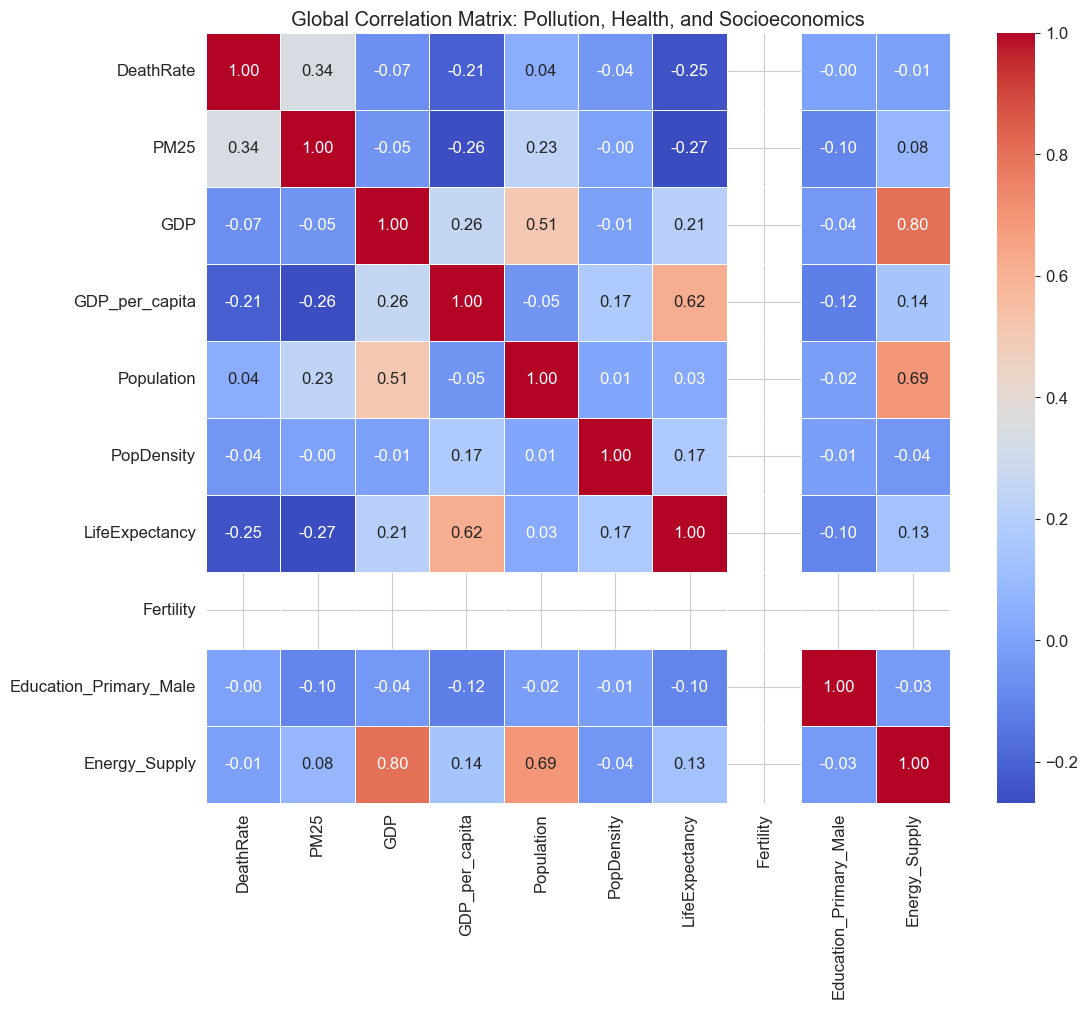

C:\Users\harsh\AppData\Local\Temp\ipykernel_1652\672826412.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pdf_master, x="Year", y="PM25", estimator="mean", ci=None, label="Avg PM2.5", linewidth=2.5)
C:\Users\harsh\AppData\Local\Temp\ipykernel_1652\672826412.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pdf_master, x="Year", y="DeathRate", estimator="mean", ci=None, label="Avg Death Rate", color="red", linewidth=2.5, ax=ax2)


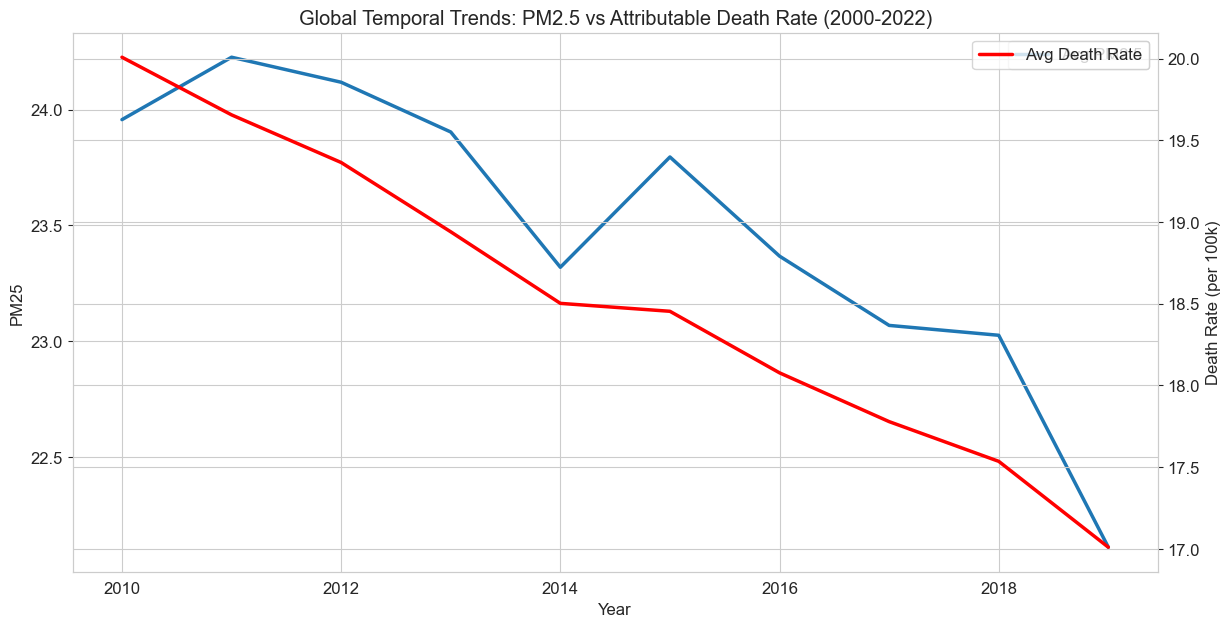

In [4]:
if not pdf_master.empty:
    # Heatmap
    numeric_cols = [c for c, t in master_df.dtypes if t in ['int', 'double', 'float'] and c != 'Year']
    corr_matrix = pdf_master[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title("Global Correlation Matrix: Pollution, Health, and Socioeconomics")
    plt.savefig("results/final_figures/1_correlation_heatmap.png", dpi=300)
    plt.show()

    # Temporal Trends
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=pdf_master, x="Year", y="PM25", estimator="mean", ci=None, label="Avg PM2.5", linewidth=2.5)
    ax2 = plt.twinx()
    sns.lineplot(data=pdf_master, x="Year", y="DeathRate", estimator="mean", ci=None, label="Avg Death Rate", color="red", linewidth=2.5, ax=ax2)
    plt.title("Global Temporal Trends: PM2.5 vs Attributable Death Rate (2000-2022)")
    ax2.set_ylabel("Death Rate (per 100k)")
    plt.savefig("results/final_figures/2_temporal_trends.png", dpi=300)
    plt.show()

## 5. Visual Narrative: Part 2 - Socioeconomic Interactions

How GDP and Population context changes the impact.

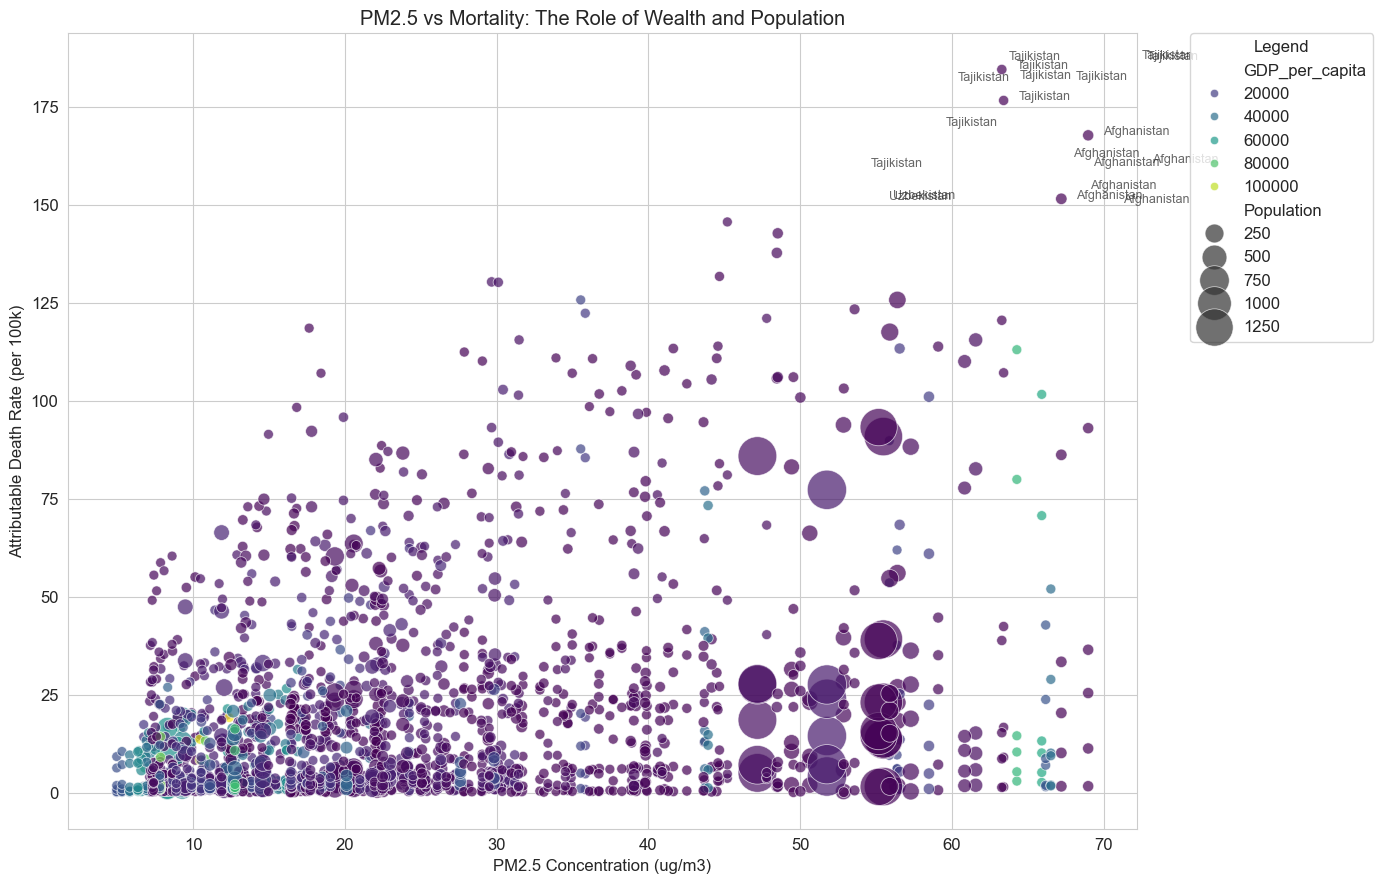

In [5]:
if not pdf_master.empty:
    # Bubble Chart
    plt.figure(figsize=(14, 9))
    scatter = sns.scatterplot(
        data=pdf_master, 
        x="PM25", 
        y="DeathRate", 
        size="Population", 
        hue="GDP_per_capita", 
        sizes=(50, 800), 
        alpha=0.7, 
        palette="viridis"
    )
    plt.title("PM2.5 vs Mortality: The Role of Wealth and Population")
    plt.xlabel("PM2.5 Concentration (ug/m3)")
    plt.ylabel("Attributable Death Rate (per 100k)")
    
    # Annotate outliers (High PM2.5 or High Death Rate)
    outliers = pdf_master[(pdf_master["PM25"] > 80) | (pdf_master["DeathRate"] > 150)]
    for i in outliers.index:
        plt.text(outliers.PM25[i]+1, outliers.DeathRate[i], outliers.Country[i], fontsize=9, alpha=0.7)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Legend")
    plt.tight_layout()
    plt.savefig("results/final_figures/3_socioeconomic_bubble_chart.png", dpi=300)
    plt.show()

## 6. Visual Narrative: Part 3 - Interaction Effects

Exploring complex multi-variable relationships.

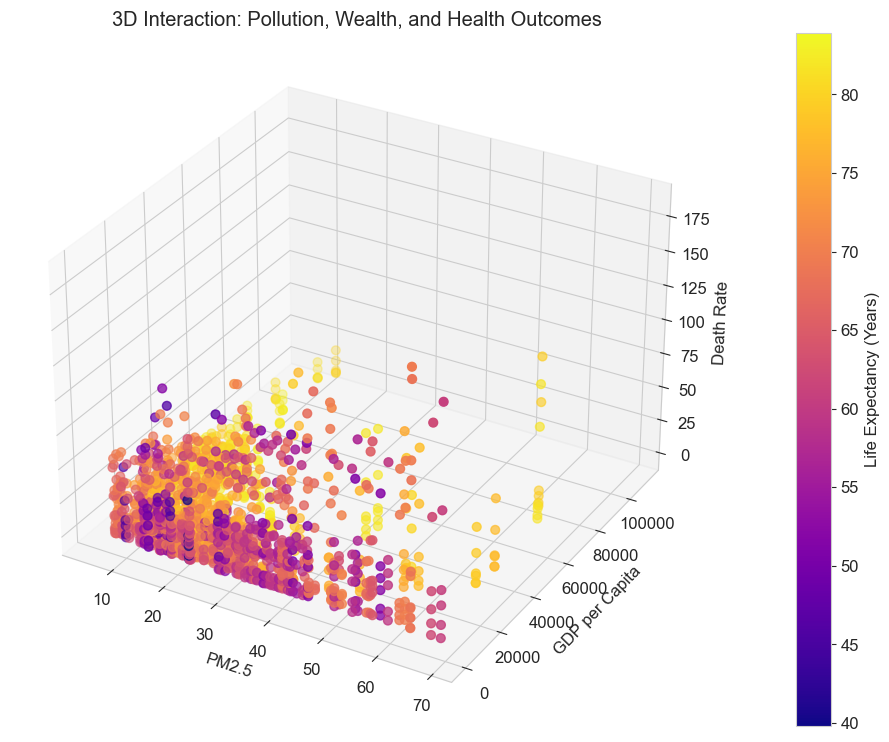

In [6]:
if not pdf_master.empty and "LifeExpectancy" in pdf_master.columns:
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(pdf_master['PM25'], pdf_master['GDP_per_capita'], pdf_master['DeathRate'], c=pdf_master['LifeExpectancy'], cmap='plasma', s=40)
    ax.set_xlabel('PM2.5')
    ax.set_ylabel('GDP per Capita')
    ax.set_zlabel('Death Rate')
    cbar = plt.colorbar(sc, pad=0.1)
    cbar.set_label('Life Expectancy (Years)')
    plt.title("3D Interaction: Pollution, Wealth, and Health Outcomes")
    plt.savefig("results/final_figures/4_3d_interaction.png", dpi=300)
    plt.show()

## 7. Formal Model Evaluation

Training multiple models and comparing their performance with formal metrics.

In [7]:
if not pdf_master.empty:
    feature_cols = [c for c in numeric_cols if c != "DeathRate"]
    model_df = master_df.select(["DeathRate"] + feature_cols).dropna()
    
    if model_df.count() > 0:
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
        scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
        (train_data, test_data) = model_df.randomSplit([0.8, 0.2], seed=42)

        models = {
            "Linear": LinearRegression(featuresCol="scaledFeatures", labelCol="DeathRate", regParam=0.0),
            "Ridge": LinearRegression(featuresCol="scaledFeatures", labelCol="DeathRate", regParam=0.1, elasticNetParam=0.0),
            "Lasso": LinearRegression(featuresCol="scaledFeatures", labelCol="DeathRate", regParam=0.1, elasticNetParam=1.0),
            "Random Forest": RandomForestRegressor(featuresCol="features", labelCol="DeathRate", numTrees=100)
        }

        results = []
        
        # Residuals plot setup
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for i, (name, model) in enumerate(models.items()):
            pipeline = Pipeline(stages=[assembler, model]) if name == "Random Forest" else Pipeline(stages=[assembler, scaler, model])
            
            try:
                model_fit = pipeline.fit(train_data)
                predictions = model_fit.transform(test_data)
                
                # Metrics
                eval_rmse = RegressionEvaluator(labelCol="DeathRate", predictionCol="prediction", metricName="rmse")
                eval_mae = RegressionEvaluator(labelCol="DeathRate", predictionCol="prediction", metricName="mae")
                eval_r2 = RegressionEvaluator(labelCol="DeathRate", predictionCol="prediction", metricName="r2")
                
                rmse = eval_rmse.evaluate(predictions)
                mae = eval_mae.evaluate(predictions)
                r2 = eval_r2.evaluate(predictions)
                
                results.append((name, rmse, mae, r2))
                
                # Residual Plot
                preds_pd = predictions.select("DeathRate", "prediction").toPandas()
                preds_pd["Residuals"] = preds_pd["DeathRate"] - preds_pd["prediction"]
                sns.scatterplot(x="prediction", y="Residuals", data=preds_pd, ax=axes[i], alpha=0.5)
                axes[i].axhline(0, color='red', linestyle='--')
                axes[i].set_title(f"{name} Residuals")
                axes[i].set_xlabel("Predicted Death Rate")
                axes[i].set_ylabel("Residual (Actual - Predicted)")
                
            except Exception as e:
                print(f"Error training {name}: {e}")
        
        plt.tight_layout()
        plt.savefig("results/final_figures/5_residual_plots.png", dpi=300)
        plt.show()

        # Save comparison table
        results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
        results_df.to_csv("results/model_evaluation_metrics.csv", index=False)
        print("Model Evaluation Complete")
        print(results_df)

## 8. Regional Deep Dives

Analyzing data by region (Europe, Africa, Asia, etc.).

C:\Users\harsh\AppData\Local\Temp\ipykernel_1652\2488282148.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="PM25", data=subset, palette="Set3")


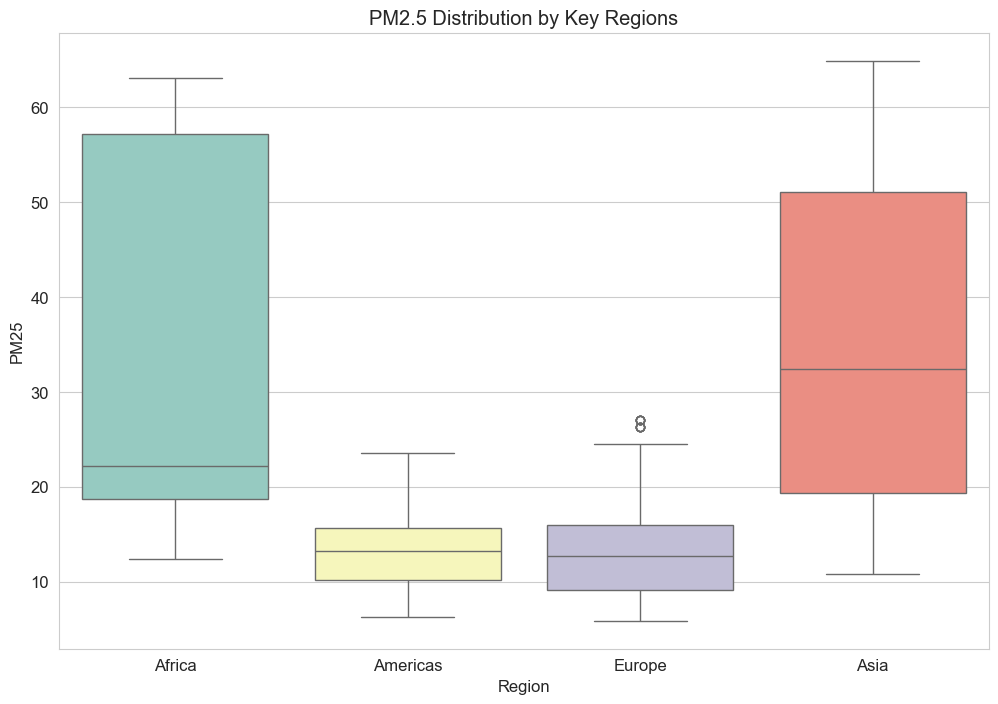

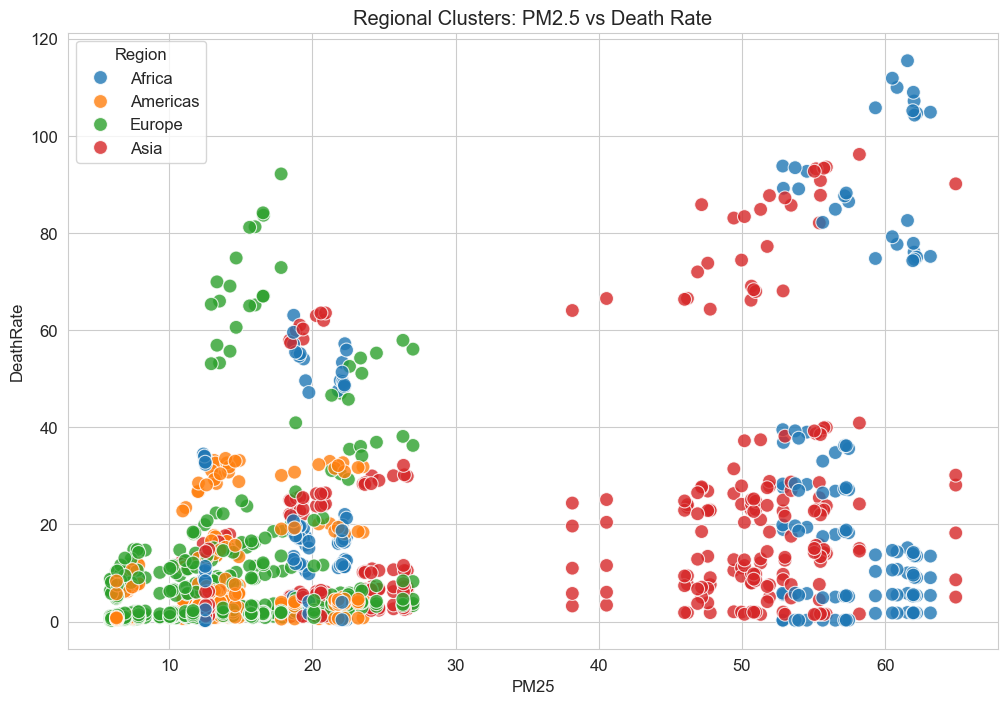

--- Profile: India ---
Latest Data (2019):
  PM2.5: 50.17
  Death Rate: 12.70
  GDP per Capita: N/A
  Life Expectancy: N/A


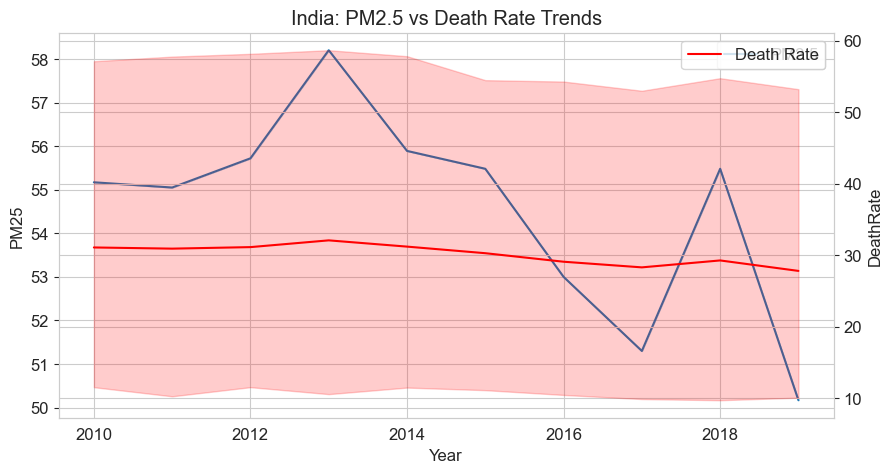

--- Profile: China ---
Latest Data (2019):
  PM2.5: 38.15
  Death Rate: 10.99
  GDP per Capita: N/A
  Life Expectancy: N/A


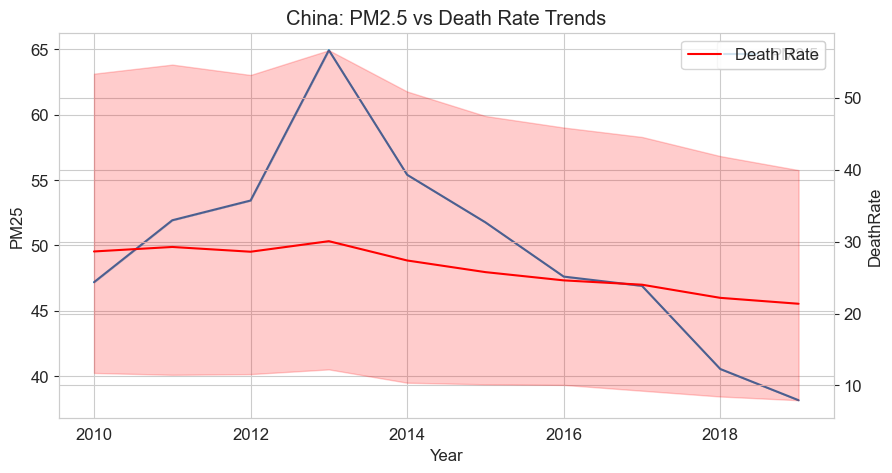

--- Profile: United States Of America ---
Latest Data (2019):
  PM2.5: 7.18
  Death Rate: 1.57
  GDP per Capita: N/A
  Life Expectancy: N/A


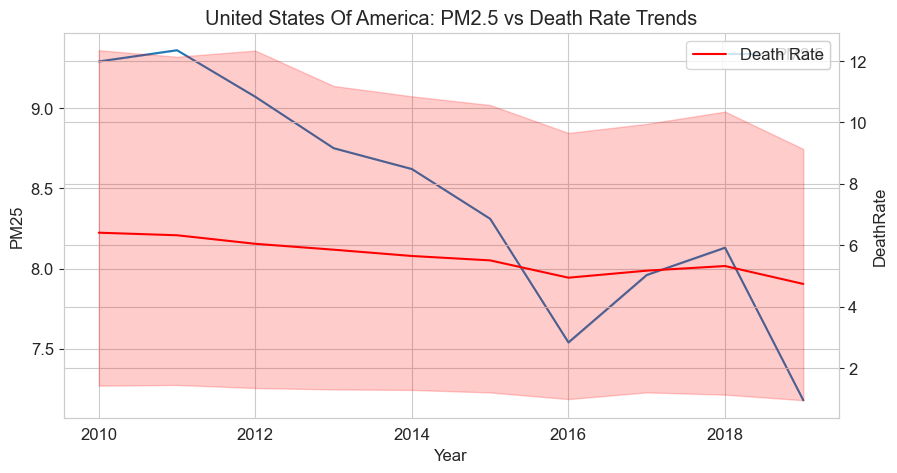

--- Profile: Nigeria ---
Latest Data (2019):
  PM2.5: 55.64
  Death Rate: 0.28
  GDP per Capita: N/A
  Life Expectancy: N/A


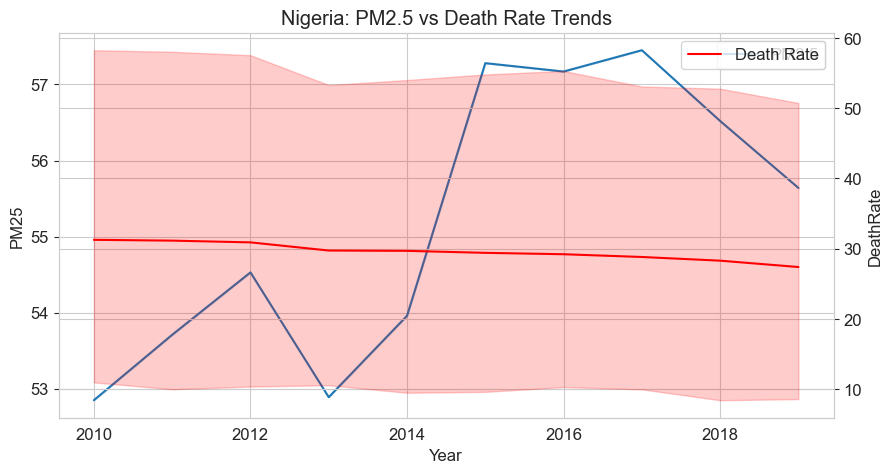

C:\Users\harsh\AppData\Local\Temp\ipykernel_1652\2488282148.py:77: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(latest_year_df, locations="Country", locationmode="country names",


C:\Users\harsh\AppData\Local\Temp\ipykernel_1652\2488282148.py:85: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



Generated Choropleth Maps


In [8]:
# Mapping countries to regions (Simplified mapping for demonstration)
# Ideally use a library or dataset join for this
# We will do a quick visual check if 'Country' string allows basic grouping or just pick a few known ones
regions = {
    "Europe": ["germany", "france", "italy", "spain", "uk", "poland", "sweden", "norway"],
    "Asia": ["china", "india", "japan", "indonesia", "vietnam", "thailand", "bangladesh"],
    "Africa": ["nigeria", "egypt", "south africa", "kenya", "ethiopia"],
    "Americas": ["usa", "canada", "brazil", "mexico", "argentina"]
}

def get_region(country):
    c = str(country).lower()
    for reg, countries in regions.items():
        for k in countries:
            if k in c:
                return reg
    return "Other"

if not pdf_master.empty:
    pdf_master["Region"] = pdf_master["Country"].apply(get_region)
    subset = pdf_master[pdf_master["Region"] != "Other"]
    
    if not subset.empty:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x="Region", y="PM25", data=subset, palette="Set3")
        plt.title("PM2.5 Distribution by Key Regions")
        plt.savefig("results/final_figures/6_regional_pm25_boxplot.png", dpi=300)
        plt.show()
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x="PM25", y="DeathRate", hue="Region", data=subset, s=100, alpha=0.8)
        plt.title("Regional Clusters: PM2.5 vs Death Rate")
        plt.savefig("results/final_figures/7_regional_scatter.png", dpi=300)
        plt.show()
        
    # Country Profile Generator
    def generate_country_profile(country_name):
        c_data = pdf_master[pdf_master["Country"].str.lower() == country_name.lower()]
        if c_data.empty:
            print(f"No data found for {country_name}")
            return
        
        print(f"--- Profile: {country_name.title()} ---")
        latest = c_data.sort_values("Year", ascending=False).iloc[0]
        print(f"Latest Data ({latest['Year']}):")
        print(f"  PM2.5: {latest['PM25']:.2f}")
        print(f"  Death Rate: {latest['DeathRate']:.2f}")
        # Handle potential missing values for safe printing
        gdp = f"${latest['GDP_per_capita']:,.2f}" if not pd.isna(latest['GDP_per_capita']) else "N/A"
        life_exp = f"{latest['LifeExpectancy']:.1f} years" if not pd.isna(latest['LifeExpectancy']) else "N/A"
        print(f"  GDP per Capita: {gdp}")
        print(f"  Life Expectancy: {life_exp}")
        
        # Plot Trends
        plt.figure(figsize=(10, 5))
        sns.lineplot(x="Year", y="PM25", data=c_data, label="PM2.5")
        ax2 = plt.twinx()
        sns.lineplot(x="Year", y="DeathRate", data=c_data, color="red", label="Death Rate", ax=ax2)
        plt.title(f"{country_name.title()}: PM2.5 vs Death Rate Trends")
        plt.savefig(f"results/final_figures/profile_{country_name.lower()}.png", dpi=300)
        plt.show()

    # Generate sample profiles
    generate_country_profile("India")
    generate_country_profile("China")
    generate_country_profile("United States of America")
    generate_country_profile("Nigeria")

    # Choropleth Maps
    import plotly.express as px
    
    if not pdf_master.empty:
        latest_year_df = pdf_master[pdf_master["Year"] == 2019] 
        
        if not latest_year_df.empty:
            # PM2.5 Map
            fig = px.choropleth(latest_year_df, locations="Country", locationmode="country names",
                                color="PM25",
                                hover_name="Country",
                                color_continuous_scale=px.colors.sequential.YlOrRd,
                                title="Global PM2.5 Concentrations (2019)")
            fig.write_image("results/final_figures/8_map_pm25.png")
            
            # Death Rate Map
            fig2 = px.choropleth(latest_year_df, locations="Country", locationmode="country names",
                                color="DeathRate",
                                hover_name="Country",
                                color_continuous_scale=px.colors.sequential.Reds,
                                title="Global Attributable Death Rates (2019)")
            fig2.write_image("results/final_figures/9_map_deathrate.png")
            
            print("Generated Choropleth Maps")